<a href="https://colab.research.google.com/github/chaerui7967/stock_predict_news_and_youtube/blob/master/lstm_%EC%9E%AC%EB%AC%B4%EC%A0%95%EB%B3%B4_%ED%98%84%EB%8C%80%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 재무지표를 포함한 lstm 종가 예측

## 라이브러리 설치

In [1]:
# 필요 라이브러리 설치
!pip install finance-datareader
!pip install pykrx

     |████████████████████████████████| 81 kB 2.6 MB/s 
     |████████████████████████████████| 60 kB 4.5 MB/s 
     |████████████████████████████████| 251 kB 7.7 MB/s 


## 패키지 로딩 및 함수 로딩

In [2]:
# 필요 라이브러리
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 주식가격 로딩
import FinanceDataReader as fdr
from pykrx import stock

import datetime

In [3]:
def money_sur(stock_name, start, end):

  # 라이브러리를 찾음... 한방에 나옴...
    start_date = start
    end_date = end
    sample_code = stock_name

    dataset = fdr.DataReader(sample_code, start = start_date, end = end_date )
    dataset = dataset.reset_index()
    df = stock.get_market_fundamental_by_date(fromdate=start_date, todate=end_date, ticker=sample_code)
    df = df.reset_index()
    df.columns = ['Date','BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS']
    data = pd.merge(dataset, df, on='Date')

    return data

## 데이터 로드

In [4]:
end_date = datetime.datetime.now().strftime("%Y%m%d")
df = money_sur('005380',2018, end_date)

In [5]:
df

,Date,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS
0,2018-01-02,150500,153000,149000,149500,731763,-0.041667,235358,7.43,0.64,20118,2.68,4000
1,2018-01-03,149000,151000,149000,150500,450874,0.006689,235358,7.48,0.64,20118,2.66,4000
2,2018-01-04,150500,151000,146000,146500,931558,-0.026578,235358,7.28,0.62,20118,2.73,4000
3,2018-01-05,146000,149000,145500,149000,463695,0.017065,235358,7.41,0.63,20118,2.68,4000
4,2018-01-08,148500,151000,147500,151000,482619,0.013423,235358,7.51,0.64,20118,2.65,4000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,2021-09-27,205000,206000,203500,204000,584898,-0.014493,250888,37.40,0.81,5454,1.47,3000
920,2021-09-28,204000,204000,200500,201500,719631,-0.012255,250888,36.95,0.80,5454,1.49,3000
921,2021-09-29,197500,202000,197500,201500,934463,0.000000,250888,36.95,0.80,5454,1.49,3000
922,2021-09-30,200000,201000,199000,200000,594666,-0.007444,250888,36.67,0.80,5454,1.50,3000


## 데이터 전처리

In [6]:
df1 = df.set_index('Date')

In [7]:
df1.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'BPS', 'PER', 'PBR',
       'EPS', 'DIV', 'DPS'],
      dtype='object')

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


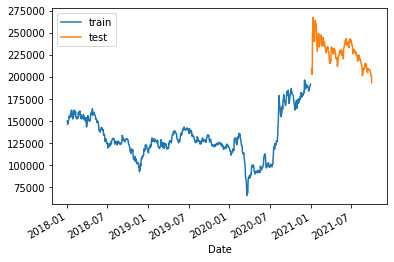

In [8]:
# test --> 21년 이후 , train --> 18~20
split_date = pd.Timestamp('01-01-2021')

train = df1.loc[:split_date, ]
test = df1.loc[split_date:, ]

ax = train['Close'].plot()
test['Close'].plot(ax=ax)
plt.legend(['train', 'test'])

In [9]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

train_sc

array([[0.63685015, 0.640625  , 0.64615385, ..., 1.        , 0.15880895,
        0.        ],
       [0.62538226, 0.625     , 0.64615385, ..., 1.        , 0.15384618,
        0.        ],
       [0.63685015, 0.625     , 0.62307692, ..., 1.        , 0.17121589,
        0.        ],
       ...,
       [0.93119266, 0.953125  , 0.94230769, ..., 0.39196466, 0.01736971,
        0.        ],
       [0.94648318, 0.94140625, 0.94615385, ..., 0.39196466, 0.01488832,
        0.        ],
       [0.94266055, 0.95703125, 0.95384615, ..., 0.39196466, 0.00992555,
        0.        ]])

In [10]:
df1.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'BPS', 'PER', 'PBR',
       'EPS', 'DIV', 'DPS'],
      dtype='object')

In [11]:
scale_cols = list(df1.columns)

train_sc_df = pd.DataFrame(train_sc, columns=[scale_cols], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=[scale_cols], index=test.index)

In [12]:
# 종가로만 예측 시
# train_close = pd.DataFrame(train_sc_df[('Close',)])
# test_close = pd.DataFrame(test_sc_df[('Close',)])

In [13]:
for i in scale_cols:
  for s in range(1, 11):  
    train_sc_df[(i+'shift_{}'.format(s),)] = train_sc_df[(i,)].shift(s)
    test_sc_df[(i+'shift_{}'.format(s),)] = test_sc_df[(i,)].shift(s)

train_sc_df.head(11)
train_sc_df.shape

(738, 132)

In [14]:
test_sc_df.shape

(186, 132)

In [15]:
train_sc_df.columns

MultiIndex([(       'Open',),
            (       'High',),
            (        'Low',),
            (      'Close',),
            (     'Volume',),
            (     'Change',),
            (        'BPS',),
            (        'PER',),
            (        'PBR',),
            (        'EPS',),
            ...
            ( 'DPSshift_1',),
            ( 'DPSshift_2',),
            ( 'DPSshift_3',),
            ( 'DPSshift_4',),
            ( 'DPSshift_5',),
            ( 'DPSshift_6',),
            ( 'DPSshift_7',),
            ( 'DPSshift_8',),
            ( 'DPSshift_9',),
            ('DPSshift_10',)],
           length=132)

In [16]:
train_sc_df.head(11)

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS,Openshift_1,Openshift_2,Openshift_3,Openshift_4,Openshift_5,Openshift_6,Openshift_7,Openshift_8,Openshift_9,Openshift_10,Highshift_1,Highshift_2,Highshift_3,Highshift_4,Highshift_5,Highshift_6,Highshift_7,Highshift_8,Highshift_9,Highshift_10,Lowshift_1,Lowshift_2,Lowshift_3,Lowshift_4,Lowshift_5,Lowshift_6,Lowshift_7,Lowshift_8,...,PBRshift_1,PBRshift_2,PBRshift_3,PBRshift_4,PBRshift_5,PBRshift_6,PBRshift_7,PBRshift_8,PBRshift_9,PBRshift_10,EPSshift_1,EPSshift_2,EPSshift_3,EPSshift_4,EPSshift_5,EPSshift_6,EPSshift_7,EPSshift_8,EPSshift_9,EPSshift_10,DIVshift_1,DIVshift_2,DIVshift_3,DIVshift_4,DIVshift_5,DIVshift_6,DIVshift_7,DIVshift_8,DIVshift_9,DIVshift_10,DPSshift_1,DPSshift_2,DPSshift_3,DPSshift_4,DPSshift_5,DPSshift_6,DPSshift_7,DPSshift_8,DPSshift_9,DPSshift_10
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0.636850,0.640625,0.646154,0.640123,0.066660,0.237565,0.0,0.064282,0.725490,1.0,0.158809,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.625382,0.625000,0.646154,0.647779,0.032741,0.423646,0.0,0.066874,0.725490,1.0,0.153846,0.0,0.636850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.640625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.646154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.725490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.158809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,0.636850,0.625000,0.623077,0.617152,0.090787,0.295629,0.0,0.056506,0.686275,1.0,0.171216,0.0,0.625382,0.636850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.625000,0.640625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.646154,0.646154,NaN,NaN,NaN,NaN,NaN,NaN,...,0.725490,0.725490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.153846,0.158809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,0.602446,0.609375,0.619231,0.636294,0.034289,0.463574,0.0,0.063245,0.705882,1.0,0.158809,0.0,0.636850,0.625382,0.636850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.625000,0.625000,0.640625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.623077,0.646154,0.646154,NaN,NaN,NaN,NaN,NaN,...,0.686275,0.725490,0.725490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.171216,0.153846,0.158809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,0.621560,0.625000,0.634615,0.651608,0.036574,0.449559,0.0,0.068429,0.725490,1.0,0.151365,0.0,0.602446,0.636850,0.625382,0.636850,NaN,NaN,NaN,NaN,NaN,NaN,0.609375,0.625000,0.625000,0.640625,NaN,NaN,NaN,NaN,NaN,NaN,0.619231,0.623077,0.646154,0.646154,NaN,NaN,NaN,NaN,...,0.705882,0.686275,0.725490,0.725490,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.158809,0.171216,0.153846,0.158809,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-09,0.640673,0.636719,0.650000,0.663093,0.034548,0.436133,0.0,0.072058,0.745098,1.0,0.143921,0.0,0.621560,0.602446,0.636850,0.625382,0.636850,NaN,NaN,NaN,NaN,NaN,0.625000,0.609375,0.625000,0.625000,0.640625,NaN,NaN,NaN,NaN,NaN,0.634615,0.619231,0.623077,0.646154,0.646154,NaN,NaN,NaN,...,0.725490,0.705882,0.686275,0.725490,0.725490,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0.151365,0.158809,0.171216,0.153846,0.158809,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2018-01-10,0.652141,0.679688,0.669231,0.686064,0.074137,0.473607,0.0,0.079834,0.764706,1.0,0.131514,0.0,0.640673,0.621560,0.602446,0.636850,0.625382,0.636850,NaN,NaN,NaN,NaN,0.636719,0.625000,0.609375,0.625000,0.625000,0.640625,NaN,NaN,NaN,NaN,0.650000,0.634615,0.619231,0.623077,0.646154,0.646154,NaN,NaN,...,0.745098,0.725490,0.705882,0.686275,0.725490,0.725490,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.

In [17]:
X_train = train_sc_df.dropna().drop(columns=scale_cols, axis=1)
y_train = train_sc_df.dropna()[['Close']]

X_test = test_sc_df.dropna().drop(columns=scale_cols, axis=1)
y_test = test_sc_df.dropna()[['Close']]

X_train.head()

,Openshift_1,Openshift_2,Openshift_3,Openshift_4,Openshift_5,Openshift_6,Openshift_7,Openshift_8,Openshift_9,Openshift_10,Highshift_1,Highshift_2,Highshift_3,Highshift_4,Highshift_5,Highshift_6,Highshift_7,Highshift_8,Highshift_9,Highshift_10,Lowshift_1,Lowshift_2,Lowshift_3,Lowshift_4,Lowshift_5,Lowshift_6,Lowshift_7,Lowshift_8,Lowshift_9,Lowshift_10,Closeshift_1,Closeshift_2,Closeshift_3,Closeshift_4,Closeshift_5,Closeshift_6,Closeshift_7,Closeshift_8,Closeshift_9,Closeshift_10,...,PBRshift_1,PBRshift_2,PBRshift_3,PBRshift_4,PBRshift_5,PBRshift_6,PBRshift_7,PBRshift_8,PBRshift_9,PBRshift_10,EPSshift_1,EPSshift_2,EPSshift_3,EPSshift_4,EPSshift_5,EPSshift_6,EPSshift_7,EPSshift_8,EPSshift_9,EPSshift_10,DIVshift_1,DIVshift_2,DIVshift_3,DIVshift_4,DIVshift_5,DIVshift_6,DIVshift_7,DIVshift_8,DIVshift_9,DIVshift_10,DPSshift_1,DPSshift_2,DPSshift_3,DPSshift_4,DPSshift_5,DPSshift_6,DPSshift_7,DPSshift_8,DPSshift_9,DPSshift_10
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-16,0.663609,0.659786,0.678899,0.652141,0.640673,0.621560,0.602446,0.636850,0.625382,0.636850,0.656250,0.664062,0.667969,0.679688,0.636719,0.625000,0.609375,0.625000,0.625000,0.640625,0.661538,0.680769,0.673077,0.669231,0.650000,0.634615,0.619231,0.623077,0.646154,0.646154,0.682236,0.674579,0.682236,0.686064,0.663093,0.651608,0.636294,0.617152,0.647779,0.640123,...,0.764706,0.745098,0.764706,0.764706,0.745098,0.725490,0.705882,0.686275,0.725490,0.725490,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.133995,0.138958,0.133995,0.131514,0.143921,0.151365,0.158809,0.171216,0.153846,0.158809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-17,0.659786,0.663609,0.659786,0.678899,0.652141,0.640673,0.621560,0.602446,0.636850,0.625382,0.679688,0.656250,0.664062,0.667969,0.679688,0.636719,0.625000,0.609375,0.625000,0.625000,0.676923,0.661538,0.680769,0.673077,0.669231,0.650000,0.634615,0.619231,0.623077,0.646154,0.705207,0.682236,0.674579,0.682236,0.686064,0.663093,0.651608,0.636294,0.617152,0.647779,...,0.784314,0.764706,0.745098,0.764706,0.764706,0.745098,0.725490,0.705882,0.686275,0.725490,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.121588,0.133995,0.138958,0.133995,0.131514,0.143921,0.151365,0.158809,0.171216,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-18,0.686544,0.659786,0.663609,0.659786,0.678899,0.652141,0.640673,0.621560,0.602446,0.636850,0.687500,0.679688,0.656250,0.664062,0.667969,0.679688,0.636719,0.625000,0.609375,0.625000,0.700000,0.676923,0.661538,0.680769,0.673077,0.669231,0.650000,0.634615,0.619231,0.623077,0.701378,0.705207,0.682236,0.674579,0.682236,0.686064,0.663093,0.651608,0.636294,0.617152,...,0.784314,0.784314,0.764706,0.745098,0.764706,0.764706,0.745098,0.725490,0.705882,0.686275,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.124069,0.121588,0.133995,0.138958,0.133995,0.131514,0.143921,0.151365,0.158809,0.171216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-19,0.690367,0.686544,0.659786,0.663609,0.659786,0.678899,0.652141,0.640673,0.621560,0.602446,0.679688,0.687500,0.679688,0.656250,0.664062,0.667969,0.679688,0.636719,0.625000,0.609375,0.684615,0.700000,0.676923,0.661538,0.680769,0.673077,0.669231,0.650000,0.634615,0.619231,0.682236,0.701378,0.705207,0.682236,0.674579,0.682236,0.686064,0.663093,0.651608,0.636294,...,0.764706,0.784314,0.784314,0.764706,0.745098,0.764706,0.764706,0.745098,0.725490,0.705882,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.133995,0.124069,0.121588,0.133995,0.138958,0.133995,0.131514,0.143921,0.151365,0.158809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-22,0.671254,0.690367,0.686544,0.659786,0.663609,0.659786,0.678899,0.652141,0.640673,0.621560,0.710938,0.679688,0.687500,0.679688,0.656250,0.664062,0.667969,0.679688,0.636719,0.625000,0.688462,0.684615,0.700000,0.676923,0.661538,0.680769,0.673077,0.669231,0.650000,0.634615,0.735835,0.682236,0.701378,0.705207,0.682236,0.674579,0.682236,0.686064,0.663093,0.651608,...,0.823529,0.764706,0.784314,0.784314,0.764706,0.745098,0.764706,0.7

In [18]:
print(type(X_train))
X_train = X_train.values
print(type(X_train))
X_test= X_test.values
y_train = y_train.values
y_test = y_test.values
 

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
(728, 120)
(728, 1)
(176, 120)
(176, 1)


In [19]:
X_train_t = X_train.reshape(X_train.shape[0], 10, 12)
X_test_t = X_test.reshape(X_test.shape[0], 10, 12)

## LSTM 실행

### tensor 사용해서 window 만들기

In [ ]:
# import tensorflow as tf

# def windowed_dataset(series, window_size, batch_size, shuffle):
#     series = tf.expand_dims(series, axis=-1)
#     ds = tf.data.Dataset.from_tensor_slices(series)
#     ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
#     ds = ds.flat_map(lambda w: w.batch(window_size + 1))
#     if shuffle:
#         ds = ds.shuffle(1000)
#     ds = ds.map(lambda w: (w[:-1], w[-1]))
#     return ds.batch(batch_size).prefetch(1)

# WINDOW_SIZE=20
# BATCH_SIZE=32

In [ ]:
# # trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
# train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
# test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
# # X: (batch_size, window_size, feature)
# # Y: (batch_size, feature)
# for data in train_data.take(1):
#     print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
#     print(f'데이터셋(Y) 구성(batch_size, feature갯수): {data[1].shape}')

### 모델

In [185]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Flatten, Dropout
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()

model.add(LSTM(64,
               input_shape = (10, 12),
               return_sequences= True))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(LSTM(64,
               input_shape = (10, 12),
               return_sequences= True))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'tanh'))
model.add(LSTM(64,
               return_sequences = False))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(100, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f26f0c094d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


In [186]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 10, 64)            19712     
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
dense_31 (Dense)             (None, 10, 32)            2080      
_________________________________________________________________
lstm_27 (LSTM)               (None, 10, 64)            24832     
_________________________________________________________________
dropout_10 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
dense_32 (Dense)             (None, 10, 32)            2080      
_________________________________________________________________
lstm_28 (LSTM)               (None, 64)              

In [187]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

# earlystopping은 30번 epoch통안 val_mse 개선이 없다면 학습 중지
earlystopping = EarlyStopping(monitor='val_mse', patience=100)
# val_mse 기준 체크포인터도 생성
filename = 'lstm_hundai.h5'
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_mse', 
                             verbose=1)

In [188]:
history = model.fit(X_train_t, y_train, validation_data=(X_test_t,y_test),
                    epochs=1000, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/1000
23/23 [==============================] - 7s 74ms/step - loss: 0.0474 - mse: 0.0949 - val_loss: 0.1947 - val_mse: 0.3895

Epoch 00001: val_mse improved from inf to 0.38946, saving model to lstm_hundai.h5
Epoch 2/1000
23/23 [==============================] - 0s 17ms/step - loss: 0.0102 - mse: 0.0205 - val_loss: 0.1342 - val_mse: 0.2684

Epoch 00002: val_mse improved from 0.38946 to 0.26837, saving model to lstm_hundai.h5
Epoch 3/1000
23/23 [==============================] - 0s 18ms/step - loss: 0.0070 - mse: 0.0140 - val_loss: 0.0847 - val_mse: 0.1694

Epoch 00003: val_mse improved from 0.26837 to 0.16940, saving model to lstm_hundai.h5
Epoch 4/1000
23/23 [==============================] - 0s 17ms/step - loss: 0.0048 - mse: 0.0096 - val_loss: 0.0287 - val_mse: 0.0575

Epoch 00004: val_mse improved from 0.16940 to 0.05749, saving model to lstm_hundai.h5
Epoch 5/1000
23/23 [==============================] - 0s 18ms/step - loss: 0.0033 - mse: 0.0067 - val_loss: 0.0250 - val_mse

In [189]:
model.load_weights(filename)
pred = model.predict(X_test_t)

In [190]:
def reverse_min_max_scaling(org_x, x): #종가 예측값
    org_x_np = np.asarray(org_x) 
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [191]:
pred.shape, y_test.shape

((176, 1), (176, 1))

In [192]:
pred_act = reverse_min_max_scaling(test['Close'], pred)

In [193]:
df_test = pd.DataFrame(pred_act, columns = ['pred'])
df_test['act'] = test['Close'][10:].values
df_test['오차'] = abs(df_test['pred'] - df_test['act'])

In [194]:
df_test

,pred,act,오차
0,283760.671875,241000,42760.671875
1,283770.054688,261500,22270.054688
2,285462.281250,259000,26462.281250
3,286150.648438,264500,21650.648438
4,286309.335938,257000,29309.335938
...,...,...,...
171,266658.117188,204000,62658.117188
172,266238.593750,201500,64738.593750
173,265836.765625,201500,64336.765625
174,265421.117188,200000,65421.117188


In [195]:
df_test['오차'].min(), df_test['오차'].max()

(21650.6484375, 71571.84375)

In [196]:
df_test['오차'].mean()

46457.48934659091

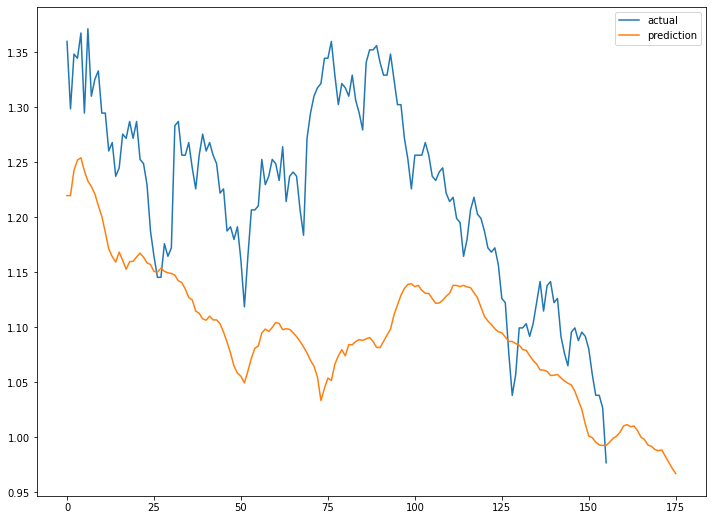

In [197]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [198]:
score = model.evaluate(X_test_t,y_test,batch_size=30)
print(score)

6/6 [==============================] - 0s 7ms/step - loss: 0.0121 - mse: 0.0242
[0.012099483981728554, 0.024198967963457108]


In [199]:
test_sc_df[('Close',)].describe()

count    186.000000
mean       1.244508
std        0.107237
min        0.977029
25%        1.172282
50%        1.250766
75%        1.317764
max        1.543645
Name: (Close,), dtype: float64

In [200]:
pd.DataFrame(pred).describe()

,0
count,176.000000
mean,1.094826
std,0.061398
min,0.967187
25%,1.058057
50%,1.095022
75%,1.135559
max,1.254180


Text(0.5, 1.0, 'Prices vs Predicted price Index: $Y_i$ vs $\\hat{Y}_i$')

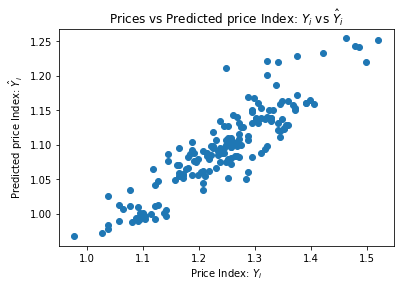

In [201]:
# 직선에 가까울 수록 정확도가 높다
y_pred = model.predict(X_test_t, batch_size=32)
plt.scatter(y_test, y_pred)
plt.xlabel("Price Index: $Y_i$")
plt.ylabel("Predicted price Index: $\hat{Y}_i$")
plt.title("Prices vs Predicted price Index: $Y_i$ vs $\hat{Y}_i$")